Further metrics:
- block creation time
- avg. waiting time
- block density

In [245]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import itertools

In [246]:
def do_step_plot(df, axis, columns, where='post'):
    myFmt = mdates.DateFormatter("%M:%S")
    axis.xaxis.set_major_formatter(myFmt)
    t_axis = pd.to_datetime(df['datetime'])
    
    for c in columns:
        axis.step(x=t_axis, y=df[c], where='post', label=c)
    axis.legend(loc='upper left')
    
def do_interval_plot(df, axis, columns, y_time, title=''):
    t_axis = pd.to_datetime(pd.Series(df.index))
    
    xFmt = mdates.DateFormatter("%M:%S")
    axis.xaxis.set_major_formatter(xFmt)
    if y_time:
        yFmt = mdates.DateFormatter("%M:%S.%f")
        axis.yaxis.set_major_formatter(yFmt)    
    for c in columns:
        if y_time:
            values = pd.to_datetime(df[c]).fillna(pd.to_datetime(0))
        else:
            values = df[c]
        axis.plot(t_axis, values, label=c)
        
    axis.legend(loc='upper left')
    axis.set_title(title)
    
def datetime_mean(x):
    return pd.Series.sum(x) / pd.Series.count(x)

In [249]:
PATH = "~/TX_backlog"
exp = "constant_tx"
node = "node1"
metric_file = "metrics.csv"


# TODO: add lane, slice, and batch_interval into underlying file / eperiment name
#n_lanes, n_slices, batch_interval = map(int, metric_file.replace('.csv', '').split('_')[-3:])
#max_capacity = n_lanes * n_slices / batch_interval
max_capacity = 0  

df = pd.read_csv(os.path.join(PATH, node, metric_file))

# create time index in nanoseconds from start
df['time'] = pd.to_datetime(df['Timestamp'], unit='ns', origin='unix')  # (D,s,ms,us,ns)
start_datetime = min(df['time'])
df['datetime'] = df['time'].apply(lambda t: (t - start_datetime))
df['time'] = df['time'].apply(lambda x: dt.datetime.timestamp(x) * 1e2)  # * 1e3 for nanoseconds, 1e2 for micro
df['time'] = df['time'] - df['time'].iloc[0]
df.index = df['time']

df['Event'] = df['Event'].astype('category')

print('Time recorded:', df['datetime'].max() - df['datetime'].min())
print('Shape: ', df.shape)
event_types = df['Event'].unique()
print('Existing events: ', event_types)
print('Event count:\n', df['Event'].value_counts())
df.head(5)

Time recorded: 0 days 00:48:58.844373
Shape:  (4540, 6)
Existing events:  [submitted, queued, stored, exec-complete, exec-started]
Categories (5, object): [submitted, queued, stored, exec-complete, exec-started]
Event count:
 submitted        908
stored           908
queued           908
exec-started     908
exec-complete    908
Name: Event, dtype: int64


,Timestamp,Instrument,Event,Identifier,time,datetime
time,,,,,,
0.0000,12819913627001,transaction,submitted,rwpWugJbzJMgic+Cwsu4xrKN2nxLsbI4MKzdmhaOgHw=,0.0000,00:00:00
0.1361,12819914988825,transaction,queued,rwpWugJbzJMgic+Cwsu4xrKN2nxLsbI4MKzdmhaOgHw=,0.1361,00:00:00.001361
0.1320,12819914947959,transaction,stored,rwpWugJbzJMgic+Cwsu4xrKN2nxLsbI4MKzdmhaOgHw=,0.1320,00:00:00.001320
0.3109,12819916736858,transaction,submitted,Pt2+6yZldxrFpSdcgFybGQVC/DzJ8HmtCngWoSa7abo=,0.3109,00:00:00.003109
0.4466,12819918093582,transaction,queued,Pt2+6yZldxrFpSdcgFybGQVC/DzJ8HmtCngWoSa7abo=,0.4466,00:00:00.004466


### Basic statistics

In [229]:
for var in event_types:
    new_name = 'Tx_{}_cumsum'.format(var)
    df[new_name] = (df['Event'] == var).cumsum()

df['Tx_exec-started_incomplete'] = df['Tx_exec-started_cumsum'] - df['Tx_exec-complete_cumsum']
df['Tx_waiting'] = df['Tx_submitted_cumsum'] - df['Tx_exec-complete_cumsum']
# indicator that we count this period
df['is_processing'] = df['Tx_waiting'] > 0

### Time statistics

In [230]:
# assumption: there is some time with no open transactions in-between
df['submission_block_id'] = (df['is_processing'] != df['is_processing'].shift()).cumsum() * df['is_processing']
df['start_end_indicator'] = df['is_processing'].astype(int).diff()
df.at[df.index[0], 'start_end_indicator'] = 1
timediffs = df[['time', 'start_end_indicator']][df['start_end_indicator'] != 0].diff()
timediffs = timediffs[timediffs['start_end_indicator'] < 0]
timediffs = timediffs.rename(columns={'time': 'duration'})
df = df.join(timediffs['duration'])
df['duration'] = df['duration'].fillna(method='backfill').fillna(value=0.) * df['is_processing'].astype(int)

# submitted transactions per 'processing_block_id'
df['n_TX'] = df.groupby('submission_block_id')['Tx_waiting'].transform(pd.Series.max)
df['T/TX'] = df['duration'] / df['n_TX']

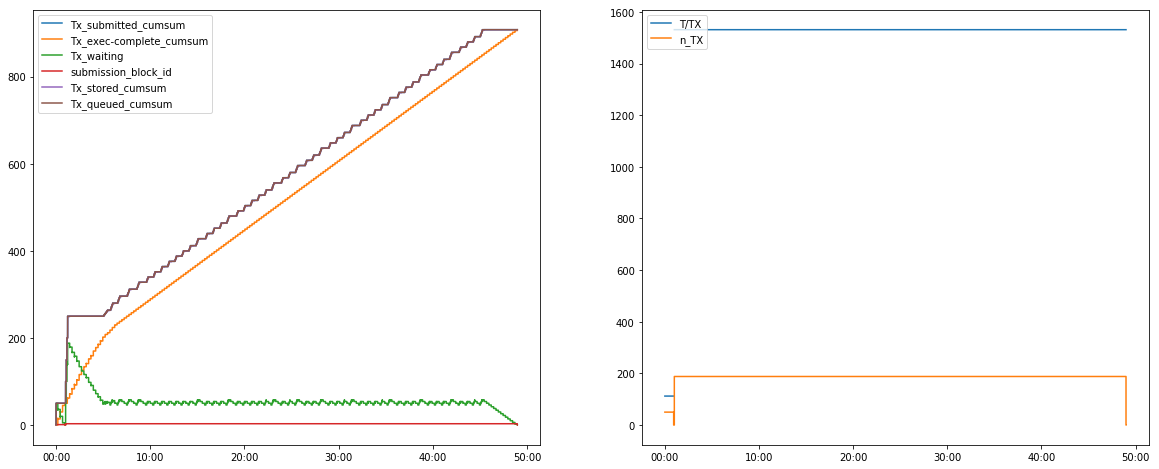

In [231]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
do_step_plot(df, ax[0], ['Tx_submitted_cumsum', 'Tx_exec-complete_cumsum', 'Tx_waiting', 'submission_block_id', 'Tx_stored_cumsum', 'Tx_queued_cumsum'])
do_step_plot(df, ax[1], ['T/TX', 'n_TX']) #'duration'

### Waiting times by identifier

In [232]:
#df.groupby(['Identifier', 'Event']).mean().unstack()

timevar = 'time' # 'datetime' or 'time', only time allows histograms
df_id = df.pivot(index='Identifier', columns='Event', values=timevar)

combs = itertools.combinations(['submitted', 'stored', 'queued', 'exec-started', 'exec-complete'], 2)

df_wait_times = pd.DataFrame()
for c in combs:
    name = '_'.join(['t', c[0], c[1]])
    df_wait_times[name] = df_id[c[1]] - df_id[c[0]]

# to add back into original df, define the wait_times to be at the time of exec:
df_tmp = df_wait_times.join(df_id['exec-complete'])
df_tmp = df_tmp.rename(columns={'exec-complete': timevar})

df = df.merge(df_tmp, on=['Identifier', timevar], how='left')

/Users/danielhonerkamp/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: 'time' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


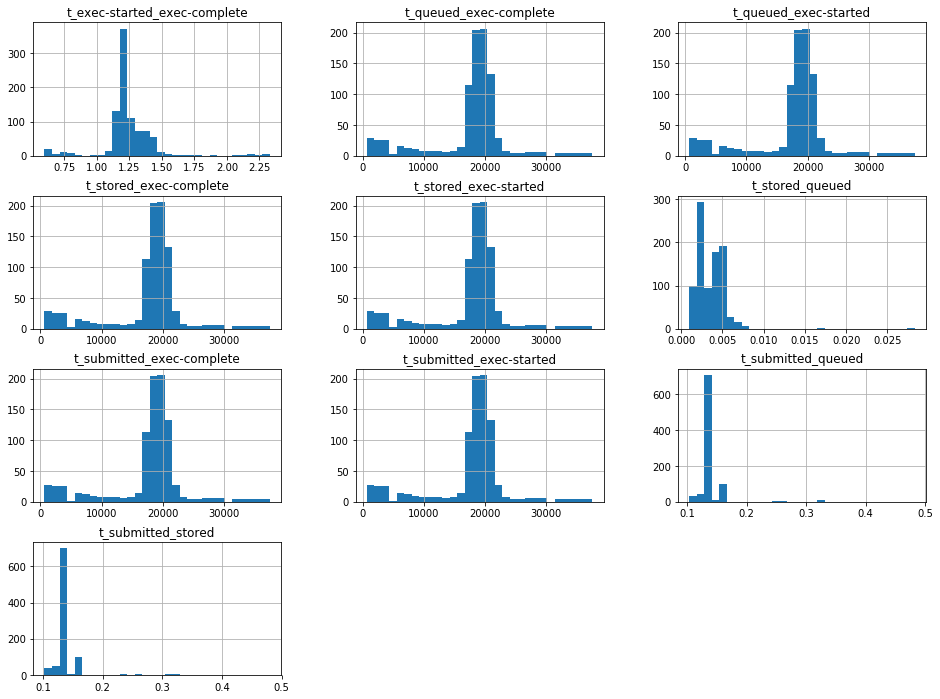

In [233]:
df_wait_times.hist(bins=30, figsize=(16,12));
#df[cols].groupby('submission_block_id').hist(bins=50, figsize=(16,12), columns=df_wait_times.columns)

In [234]:
cols = list(df_wait_times.columns) + ['submission_block_id']
df[cols].groupby('submission_block_id').agg([datetime_mean, 'count', 'std'])

t_submitted_stored                 t_submitted_queued  \
                         datetime_mean count       std      datetime_mean   
submission_block_id                                                         
0                             0.133400     2  0.003677           0.135750   
1                             0.129990    49  0.003863           0.132859   
3                             0.136493   857  0.028255           0.140149   

                                    t_submitted_exec-started        \
                    count       std            datetime_mean count   
submission_block_id                                                  
0                       2  0.003465             13919.229400     2   
1                      49  0.004083              2738.796688    49   
3                     857  0.028715             18497.326164   857   

                                  t_submitted_exec-complete    ...     \
                              std             datetime_mean    ...      
submission_block_id                                            ...      
0                    11769.874256              13920.182450    ...      
1                     1450.821155               2739.557180    ...      
3                     5323.477346              18498.594251    ...      

                    t_stored_exec-complete t_queued_exec-started        \
                                       std         datetime_mean count   
submission_block_id                                                      
0                             11770.272003          13919.093650     2   
1                              1450.847544           2738.663829    49   
3                              5323.504244          18497.186015   857   

                                  t_queued_exec-complete                      \
                              std          datetime_mean count           std   
submission_block_id                                                            
0                    11769.877721           13920.046700     2  11770.271791   
1                     1450.821046            2739.424320    49   1450.847424   
3                     5323.476553           18498.454102   857   5323.504206   

                    t_exec-started_exec-complete                  
                                   datetime_mean count       std  
submission_block_id                                               
0                                       0.953050     2  0.394071  
1                                       0.760492    49  0.159705  
3                                       1.268087   857  0.151648  

[3 rows x 30 columns]

### Executions per time interval

In [235]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(df['duration'][:])

#bins = pd.interval_range(start=0, end=df.index.max(), freq=10000)
#bins
#
#a, retbins = pd.cut(df.index, bins, include_lowest=True, right=False, retbins=True)
#df.groupby(a).sum()

In [240]:
freq = '30s'
df_event_dummies = pd.get_dummies(df, columns=['Event'])

if timevar == 'datetime':
    t_mean = datetime_mean
else:
    t_mean = pd.Series.mean

event_cols = {col: 'sum' for col in df_event_dummies if col.startswith('Event')}
t_cols     = {col: t_mean for col in df_wait_times}
agg = {**event_cols, **t_cols}


interval_df = df_event_dummies.groupby(pd.Grouper(key='datetime', freq=freq)).agg(agg)

interval_df['Max_capacity'] = max_capacity
interval_df.head()

,Event_exec-started,t_submitted_exec-complete,t_stored_exec-started,t_submitted_queued,Event_stored,t_queued_exec-complete,t_exec-started_exec-complete,t_submitted_stored,Event_exec-complete,Event_submitted,t_stored_queued,t_stored_exec-complete,Event_queued,t_submitted_exec-started,t_queued_exec-started,Max_capacity
datetime,,,,,,,,,,,,,,,,
00:00:00,32,1831.322347,1830.444412,0.132744,50,1831.189603,0.748013,0.129922,32,50,0.002822,1831.192425,50,1830.574334,1830.441591,0
00:00:30,18,4512.962922,4512.054583,0.133361,0,4512.829561,0.777894,0.130444,18,0,0.002917,4512.832478,0,4512.185028,4512.051667,0
00:01:00,22,1721.340964,1719.946077,0.132173,200,1721.208791,1.265709,0.129177,22,200,0.002995,1721.211786,200,1720.075255,1719.943082,0
00:01:30,22,4626.611436,4625.268605,0.134677,0,4626.476759,1.212100,0.130732,22,0,0.003945,4626.480705,0,4625.399336,4625.264659,0
00:02:00,22,7620.161395,7618.829305,0.133868,0,7620.027527,1.201555,0.130536,22,0,0.003332,7620.030859,0,7618.959841,7618.825973,0


In [242]:
def select_cols(columns, start):
    return [c for c in columns if c.startswith(start)]

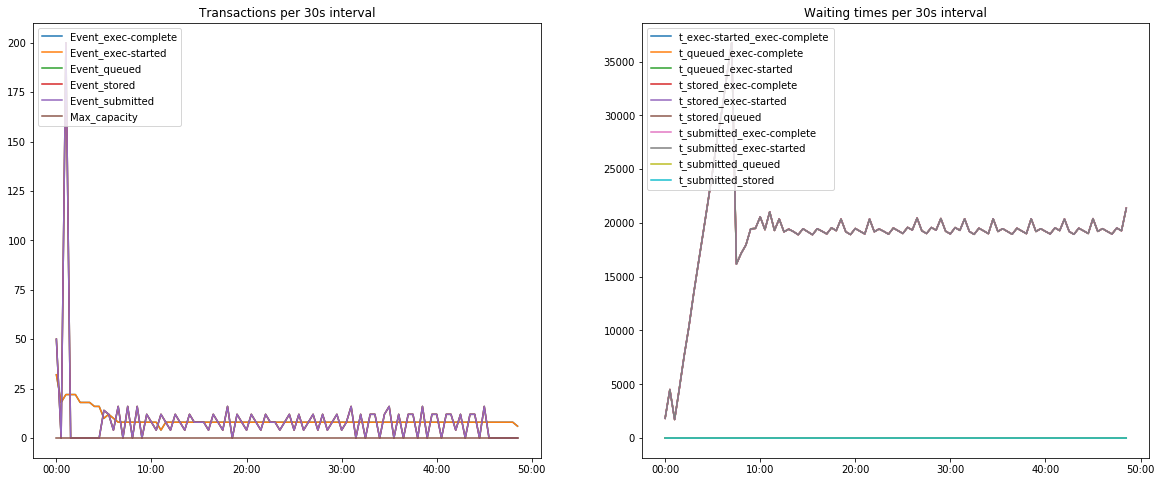

In [243]:
cols1 = sorted(list(event_cols.keys())) + ['Max_capacity']
cols2 = sorted(list(t_cols.keys()))

f, axes = plt.subplots(1, 2, figsize=(20, 8))
do_interval_plot(interval_df, axes[0], cols1, y_time=False, title='Transactions per {} interval'.format(freq))
axes[0].plot()
do_interval_plot(interval_df, axes[1], cols2, y_time=(timevar=='datetime'), title='Waiting times per {} interval'.format(freq))

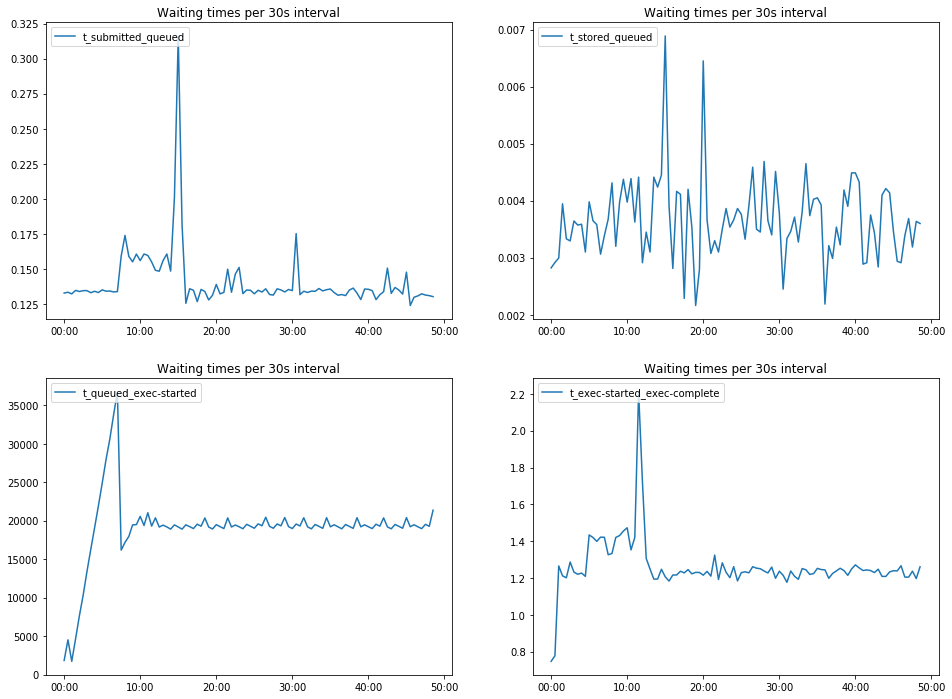

In [244]:
f, axes = plt.subplots(2, 2, figsize=(16, 12))
do_interval_plot(interval_df, axes[0, 0], ['t_submitted_queued'], y_time=(timevar=='datetime'), title='Waiting times per {} interval'.format(freq))
do_interval_plot(interval_df, axes[0, 1], ['t_stored_queued'], y_time=(timevar=='datetime'), title='Waiting times per {} interval'.format(freq))
do_interval_plot(interval_df, axes[1, 0], ['t_queued_exec-started'], y_time=(timevar=='datetime'), title='Waiting times per {} interval'.format(freq))
do_interval_plot(interval_df, axes[1, 1], ['t_exec-started_exec-complete'], y_time=(timevar=='datetime'), title='Waiting times per {} interval'.format(freq))